In [1]:
from align_spheroid import CellSimulator, Aligner2D
from align_spheroid.evaluation import (
    compare_paths, procrustes_distance, hausdorff_distance, earth_movers_distance, 
    frechet_distance, relative_movement, normalize_distance, distance_matrix_error,
    alignment_accuracy, build_long_true, calc_accuracy
)
from align_spheroid.alignment import convert_raw_to_long
import matplotlib.pyplot as plt
from matplotlib import patches
import matplotlib.patheffects as path_effects
import seaborn as sns
import numpy as np
import pandas as pd
import scipy as sp
import os
from tqdm.auto import tqdm
from IPython.core.display import HTML

out_dir = "output"

In [2]:
# Simulation parameters
timepoints = ["0h", "24h", "48h", "72h", "168h"]
n_circles = 6
width = 1000
height = 1000

# create a random number generator instance for consistent seeding
rng = np.random.default_rng(seed = 42)

# Define rotations, translations, and individual movements for each time point
rotations = [rng.uniform(0, 360) for _ in range(len(timepoints) - 1)]
translations = [(rng.integers(0, 50), rng.integers(0, 50)) for _ in range(len(timepoints) - 1)]

# Example: Move cell 'a' 10% of its radius or distance to nearest neighbor at each time point
# individual movement given by a list of dictionaries with point labels as keys and 
# percentage movement by values
# the total number of dictionaries should match the total number of time steps to perturb
individual_movements = [
    {'a': 0.01, 'b':0.05, 'c': 0.05, 'd': 0.02, 'e': 0.06, 'f':0.03},  
    {'a': 0.01, 'b':0.05, 'c': 0.05, 'd': 0.02, 'e': 0.06, 'f':0.03}, 
    {'a': 0.01, 'b':0.05, 'c': 0.05, 'd': 0.02, 'e': 0.06, 'f':0.03}, 
    {'a': 0.01, 'b':0.05, 'c': 0.05, 'd': 0.02, 'e': 0.06, 'f':0.03},
] 

# Create a simulator instance
simulator = CellSimulator(n_circles=n_circles, width=width, height=height, rng=rng)

In [3]:
# Run the simulation
simulated_data = simulator.simulate(
    time_points=timepoints, 
    rotations=rotations, 
    translations=translations, 
    individual_movements=individual_movements,
    mvmnt_type='min'
)

In [4]:
simulated_data_long = convert_raw_to_long(simulated_data, point_name='label')

In [5]:
simulated_data_long_true = build_long_true(simulated_data, n_circles, timepoints)

In [6]:
# prep the data for alignment
dataX = simulated_data[[col for col in simulated_data.columns if 'x' in col]].values #transpose
dataY = simulated_data[[col for col in simulated_data.columns if 'y' in col]].values #transpose

In [7]:
# Create an Aligner2D instance
aligner = Aligner2D(well_name="Simulation with Rotation, Translation, & Multipoint Jitter", time_points=timepoints)

# get the labels to use for the alignment
labels = list(simulated_data.label)

# Align the data (well_id 0 is just an example)
aligner = aligner.align(dataX, dataY, labels_0=labels)

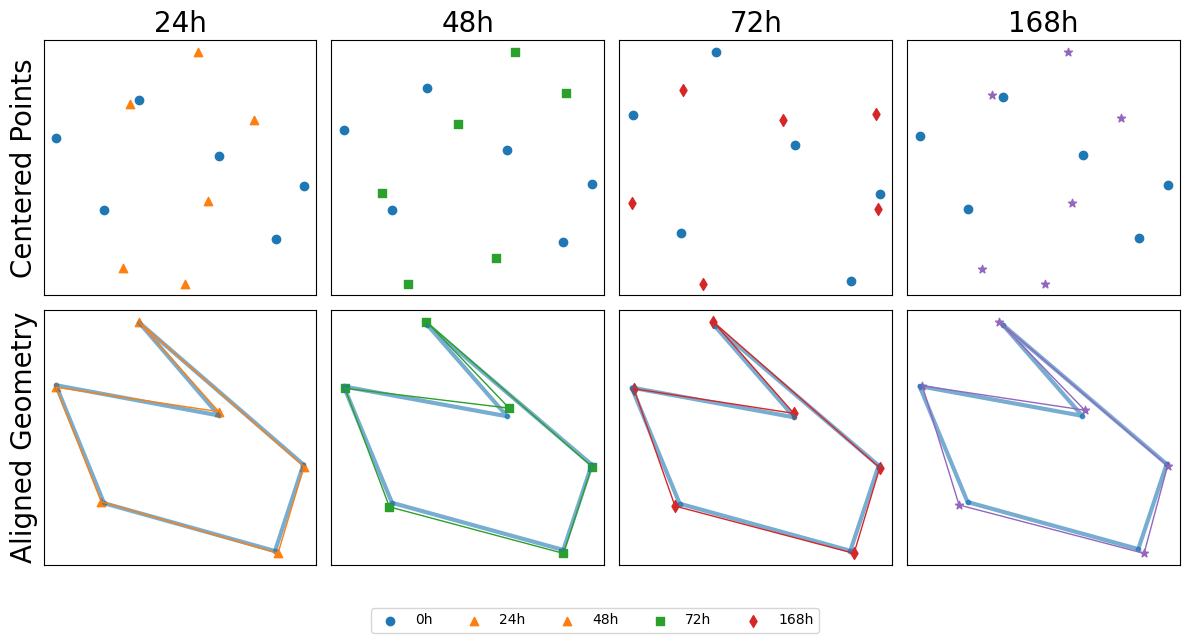

In [9]:
fig, axs = plt.subplots(2, len(timepoints) - 1, figsize=(12, 6))  # Adjust figsize as needed
aligner.plot(fig=fig, axs=axs, show_plot=False)  # Pass fig and axs
axs[0][0].set_ylabel('Centered Points', fontsize=20)
axs[1][0].set_ylabel('Aligned Geometry', fontsize=20)
axs[0][0].set_title('24h', fontsize=20)
axs[0][1].set_title('48h', fontsize=20)
axs[0][2].set_title('72h', fontsize=20)
axs[0][3].set_title('168h', fontsize=20)
fig.texts[0].set_text('')
plt.tight_layout()
#plt.show()
fig.savefig(os.path.join(out_dir, "rotation_translation_mpjitter_alignment_large_font.png"), dpi=300, bbox_inches='tight')

In [10]:
def calc_accuracy(true_labels, pred_labels):
    n = len(true_labels)
    true_preds = true_labels == pred_labels
    n_true = sum(true_preds)
    accp = n_true/n *100
    return accp, true_preds
accp, _ = calc_accuracy(simulated_data_long_true['true_label'], aligner.registered_df['aligned_label'])
print(f"Accuracy: {accp}")

Accuracy: 100.0


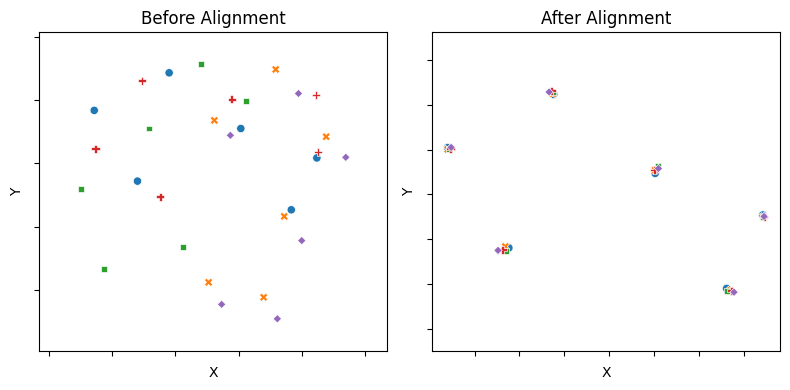

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ax = ax.ravel()

# before alignment
sns.scatterplot(
    data = simulated_data_long,
    x = 'raw_x',
    y = 'raw_y',
    hue = 'Timepoint', #'Original Point Name', 
    style = 'Timepoint',
    ax=ax[0],
    legend=False
)
ax[0].set_xlabel('X')
ax[0].set_ylabel('Y')
ax[0].set_title('Before Alignment')
ax[0].set_xticklabels([])
ax[0].set_yticklabels([])
ax[0].axis('equal')
#leg = ax[0].legend(loc="upper center", bbox_to_anchor=(1.0, 0.4, 0.5, 0.5))

t0_pts = pd.DataFrame(aligner.centeredA, columns = ['registered_x', 'registered_y'])
t0_pts['timepoint'] = '0h'

df = pd.concat([
    t0_pts,
    aligner.registered_df[['registered_x', 'registered_y', 'timepoint']]
], axis=0)

# after alignment
sns.scatterplot(
    data = df,
    x = 'registered_x',
    y = 'registered_y',
    hue = 'timepoint', 
    style = 'timepoint',
    ax=ax[1],
    legend=False
)
ax[1].set_xlabel('X')
ax[1].set_ylabel('Y')
ax[1].set_title('After Alignment')
ax[1].set_xticklabels([])
ax[1].set_yticklabels([])
ax[1].axis('equal')

#fig.suptitle('Simulated Points: Rotation, Translation, and Multipoint Jitter')
fig.savefig(os.path.join(out_dir, "simulated_rot_tran_mpjitter_before_after_hori.png"), dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()
plt.close()

In [ ]:
### Jitter - single point
# Simulation parameters
time_points = ["0h", "24h"]
n_circles = 5
width = 1000
height = 1000
jitter_percents = np.arange(0,2.1,0.1)
#jitter_percents = np.arange(0,0.1,3)

# want to run the simulation with different initial conditions replicates
n_ics_replicates = 50
replicates = np.arange(n_ics_replicates)

# want to run each replicate n times...
n_simulations = 100

# calculate the number of iterations for each loop
n_jitters = len(jitter_percents)
total_sims = n_ics_replicates * n_jitters * n_simulations

# need to store all of the simulation output...
error_distances = np.zeros((n_ics_replicates, n_simulations, n_jitters))
accuracies = np.zeros((n_ics_replicates, n_simulations, n_jitters))

# for each replicate
with tqdm(
    total=total_sims,
    desc='Overall',
    position=0,
    colour='green',
    leave=True,
    #bar_format = bar_format
) as pbar_overall:
    for r, replicate in enumerate(replicates):
        # create a new simulator with a new rng
        rng = np.random.default_rng()
        simulator = CellSimulator(n_circles=n_circles, width=width, height=height, rng=rng)
        initial_df = simulator.circles_df 
        
        # for each translation percent, do a jittering
        for i, perc in enumerate(jitter_percents):
            for sim in range(n_simulations):
                # Reset the simulator's circles_df to the initial state for each iteration
                simulator.circles_df = initial_df.copy() # copy to prevent modification via pointer
                rotations = None 
                translations = None 
                # Individual movement for the first point only (label 'a') at 24h time point
                individual_movements = [{'a': perc}]
                simulated_data = simulator.simulate(
                    time_points=time_points, rotations=rotations, translations=translations, 
                    individual_movements=individual_movements, mvmnt_type='min' 
                ) 
                dataX = simulated_data[[col for col in simulated_data.columns if 'x' in col]].values
                dataY = simulated_data[[col for col in simulated_data.columns if 'y' in col]].values
            
                aligner = Aligner2D(well_name=f"Simulation-{r-i}", time_points=time_points)
                aligner = aligner.align(dataX, dataY, labels_0=list(simulated_data.label))
                aligned_points = aligner.aligned_points
                error_distances[r, sim, i] = normalize_distance(aligned_points[0], frechet_distance(aligned_points[0], aligned_points[1]))

                simulated_long = build_long_true(simulated_data, n_circles, time_points)
                acc, _ = calc_accuracy(simulated_long['true_label'].values, aligner.registered_df['aligned_label'].values)
                accuracies[r, sim, i] = acc
                
                pbar_overall.update(1) # Update the overall bar once per alignment
                
error_distances_flat = np.concatenate(error_distances, axis=0)
accuracies_flat = np.concatenate(accuracies, axis=0)

In [ ]:
# figure parameters
title_fs = 22
annot_fs = 14
label_fs = 18
tick_fs = 14

# for showing a linear regression
err_avg = error_distances_flat.mean(axis=0)
acc_avg = accuracies_flat.mean(axis=0)
linreg = sp.stats.linregress(err_avg, acc_avg)
point=(0, linreg.intercept)
slope=linreg.slope

fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(err_avg, acc_avg, label='Simulated Spheroids')
#ax.axline(point, slope=slope, color='red', 
#          label=f'y={np.round(slope, 2)}x + {np.round(point[1],2)}\n p={np.round(linreg.pvalue)}, R={np.round(linreg.rvalue, 2)}')
ax.set_xlabel('Mean Normalized Frechét Distance', fontsize=label_fs)
ax.set_ylabel('Accuracy (%)', fontsize=label_fs)
#ax.set_title('Alignment Accuracy as a Function of Normalized Frechét Distance', fontsize=title_fs)
#leg=ax.legend(loc='upper right')#, bbox_to_anchor=(1.0, 0.2, 0.5, 0.5), fontsize=annot_fs)
fig.savefig(os.path.join(out_dir, "norm_frechet_vs_accuracy.png"), dpi=300, bbox_inches='tight')
plt.show()
plt.close()